# 2. Moview Review dataset
### The data is based on [plority dataset v2.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/mix20_rand700_tokens_cleaned.zip)

In [1]:
from glob import glob
import re
import pandas as pd

# all non alphanumeric
contractions = re.compile(r"'|-")
symbols = re.compile(r'(\W+)', re.U)
numeric = re.compile(r'(?<=\s)(\d+|\w\d+|\d+\w)(?=\s)', re.I)
swrd = re.compile(r'(?<=\s)(,|"|\(|\)|to|a|as|the|an|and|or|for|are|is)(?=\s)', re.I)
suffix = re.compile(r'(?<=\w)(s|ings*|ly|(?<=e)[sd]+)(?=\s)')
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = u' ' +  text.lower() + u' '
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = numeric.sub('000', text)
    text = swrd.sub(' ', text)
    #text = suffix.sub('', text)
    text = seps.sub(' ', text)
    return text

def preprocess(f_dir):
    data = []
    for f in glob(f_dir + '*/*.txt'):
        d = open(f,'r').read()
        lab = f.split('/')[-2]
        txt = clean(d)
        data.append([lab,txt])
    return pd.DataFrame(data=data,columns=['label','txt'])

In [ ]:
df = preprocess('data/review_polarity/txt_sentoken/')
from sklearn.cross_validation import train_test_split
train_ind, test_ind = train_test_split(df.index.tolist(),test_size=0.3)
train_df = df.iloc[train_ind]
test_df = df.iloc[test_ind]

## Deepir

In [17]:
import numpy as np
from gensim.models import Word2Vec
from gensim.models import Phrases
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

Couldn't import dot_parser, loading of dot files will not be possible.


In [20]:
# define a review generator
alteos = re.compile(r'( [!\?] )')

def revsplit(l):
    l = alteos.sub(r' \1 . ', l).rstrip("( \. )*\n")
    return [s.split() for s in l.split(" . ")]

def Reviews(df):
    data = []
    for lab,txt in df.values:
        data.append([lab,revsplit(txt)])
    return pd.DataFrame(data=data,columns=['label','txt'])

In [21]:
%time preprocessed_train_df = Reviews(train_df)
all_sentences = [s for r in preprocessed_train_df.txt for s in r]
len(all_sentences)

CPU times: user 196 ms, sys: 24 ms, total: 220 ms
Wall time: 212 ms


47935

In [22]:
jointmodel = Word2Vec(workers=16)
np.random.shuffle(all_sentences)
jointmodel.build_vocab(all_sentences)

In [29]:
docgrp = {'neg': 'neg', 'pos': 'pos'} 
model = { g: deepcopy(jointmodel) for g in docgrp }

reviews = {}
reviews['neg'] = preprocessed_train_df[preprocessed_train_df['label'] == 'neg'].txt.values
reviews['pos'] = preprocessed_train_df[preprocessed_train_df['label']=='pos'].txt.values

In [30]:
def trainW2V(g, T=20):
    sent = [l for r in reviews[g] for l in r]
    model[g].min_alpha = model[g].alpha
    for epoch in range(T):
        print epoch, " "
        np.random.shuffle(sent)
        model[g].train(sent)
        model[g].alpha *= 0.9  
        model[g].min_alpha = model[g].alpha  
    print(".")

In [31]:
for g in docgrp: 
    print g, ": "
    trainW2V( g )

neg : 
0  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
.


pos : 
0  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
.


In [32]:
%time preprocessed_test_df = Reviews(test_df)
testrev = {}
testrev['neg'] = preprocessed_test_df[preprocessed_test_df['label'] == 'neg'].txt.values
testrev['pos'] = preprocessed_test_df[preprocessed_test_df['label']=='pos'].txt.values

CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 134 ms


In [33]:
def getprobs(rev, grp,by = 'average'):
    if by == 'average':
        sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
        eta = pd.DataFrame(
                { g: model[g].score([s for i,s in sentences])  
                 for g in grp } )
        probs = eta.subtract( eta.max('columns'), 'rows') 
        probs = np.exp( probs )
        probs = probs.divide(probs.sum('columns'), "rows")
        probs['cnt'] = 1
        probs = probs.groupby([i for i,s in sentences]).sum()
        probs = probs.divide(probs["cnt"], 'rows').drop("cnt", 1)
    elif by == 'product':
        sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
        eta = pd.DataFrame(
                { g: model[g].score([s for i,s in sentences])  
                 for g in grp } )
        probs = eta.groupby([i for i,s in sentences]).sum()
        probs = probs.subtract( probs.max('columns'), 'rows')
        probs = np.exp( probs )
        probs = probs.divide(probs.sum('columns'), "rows")
    return(probs)

          mcr    n
neg  0.182410  307
pos  0.187713  293

Overall MCR: 0.185


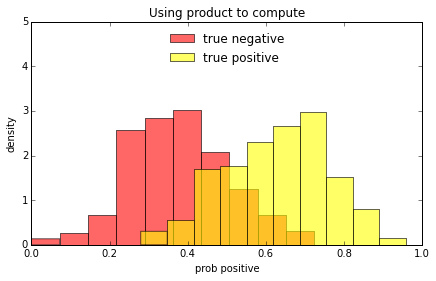

In [34]:
## by average
probs = {g: getprobs(testrev[g], docgrp, by='average') for g in docgrp }

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,4))
plt.hist(probs['neg']['pos'],normed=1,
    color="red", alpha=.6, label="true negative", linewidth=1)
plt.hist(probs['pos']['pos'],normed=1,
    color="yellow", alpha=.6, label="true positive", linewidth=1)
plt.xlim([0,1])
plt.ylim([0,5])
plt.legend(frameon=False, loc='upper center')
plt.xlabel("prob positive")
plt.ylabel("density")
plt.title('Using product to compute')

yhat = {g: probs[g].idxmax('columns') for g in docgrp}
mc = pd.DataFrame({
    'mcr': {g: (yhat[g] != g).mean() for g in docgrp},
    'n': {g: len(testrev[g]) for g in docgrp}
    })
print(mc)

overall = mc.product("columns").sum()/mc['n'].sum()
print("\nOverall MCR: %.3f" %overall)

          mcr    n
neg  0.185668  307
pos  0.146758  293

Overall MCR: 0.167


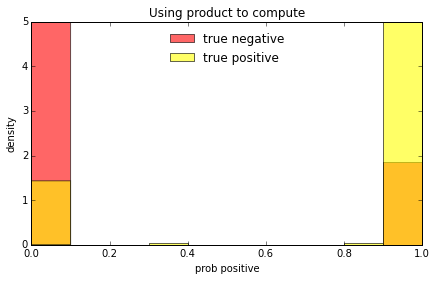

In [35]:
## by product
probs = {g: getprobs(testrev[g], docgrp, by='product') for g in docgrp }

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,4))
plt.hist(probs['neg']['pos'],normed=1,
    color="red", alpha=.6, label="true negative", linewidth=1)
plt.hist(probs['pos']['pos'],normed=1,
    color="yellow", alpha=.6, label="true positive", linewidth=1)
plt.xlim([0,1])
plt.ylim([0,5])
plt.legend(frameon=False, loc='upper center')
plt.xlabel("prob positive")
plt.ylabel("density")
plt.title('Using product to compute')

yhat = {g: probs[g].idxmax('columns') for g in docgrp}
mc = pd.DataFrame({
    'mcr': {g: (yhat[g] != g).mean() for g in docgrp},
    'n': {g: len(testrev[g]) for g in docgrp}
    })
print(mc)

overall = mc.product("columns").sum()/mc['n'].sum()
print("\nOverall MCR: %.3f" %overall)